In [1]:
# Import required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the data
music_df = pd.read_csv(r"..\data\music_clean.csv")

# Create X and y
X = music_df.drop(["loudness", "Unnamed: 0"], axis=1).values
y = music_df["loudness"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Build steps for the pipeline
steps = [("imputer", SimpleImputer()), 
         ("scaler", StandardScaler()),
         ("lasso", Lasso())]

# Create the parameter space
parameters = {
    "lasso__alpha": np.linspace(0.1, 1.0, 10),
    }

# Create the pipeline
pipeline = Pipeline(steps)

# Instantiate the grid search object
cv = GridSearchCV(pipeline, param_grid=parameters, scoring="r2")

# Fit to the training data
cv.fit(X_train, y_train)
print("Best parameters:\n", cv.best_score_, "\n", cv.best_params_)

# Make predictions on the test set
y_pred = cv.predict(X_test)

# Calculate the test_rmse
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
test_r2 = r2_score(y_test, y_pred)
test_mean_absolute_percentage_error = mean_absolute_percentage_error(y_test, y_pred)
print("Test Set \n RMSE: {}\n r^2: {}\n MAPE: {} ".format(test_rmse, test_r2, test_mean_absolute_percentage_error))



Best parameters:
 0.7075995634982774 
 {'lasso__alpha': 0.1}
Test Set 
 RMSE: 2.592126272095161
 r^2: 0.7485309417551808
 MAPE: 0.24717703767909574 


In [3]:
# Create a KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

lasso = Lasso(alpha=cv.best_params_["lasso__alpha"])

# Compute k-fold cross-validation scores
cv_scores = cross_val_score(lasso, X_train, y_train, scoring="r2", cv=kf)

print("K-Fold Cross Validation \n Mean of r^2: {}\n Standard Deviation of r^2: {}\n Confidence Interval: {} ".format(cv_scores.mean(), cv_scores.std(), np.quantile(cv_scores, [0.025, 0.975])))

K-Fold Cross Validation 
 Mean of r^2: 0.6843890987074971
 Standard Deviation of r^2: 0.03311409143625201
 Confidence Interval: [0.6369938 0.7269194] 


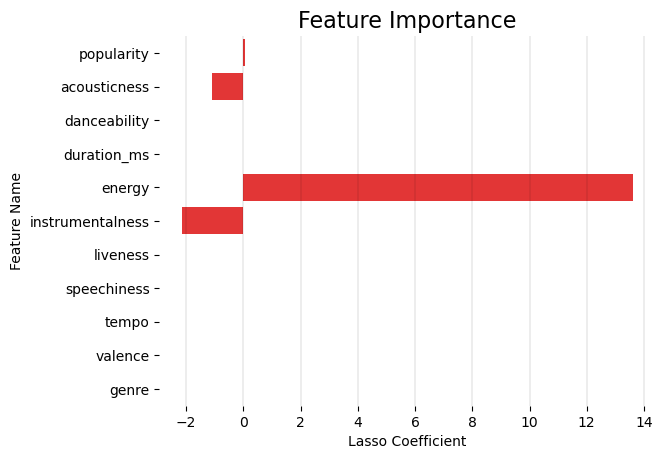

In [7]:
lasso = Lasso(alpha=cv.best_params_["lasso__alpha"])
lasso.fit(X_train, y_train)

plt.grid(color='k', linestyle='-', linewidth=0.1)
sns.barplot(y=music_df.drop(["loudness", "Unnamed: 0"], axis=1).columns, 
            x=lasso.coef_, 
            color='red',
            alpha = 0.9, 
            orient='h')

plt.title('Feature Importance', fontsize=16)
plt.xlabel('Lasso Coefficient')
plt.ylabel('Feature Name')
sns.despine(left=True, bottom=True)
plt.show()